`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")


In [3]:
variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dset_dict_old_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_new_gn = merge_variables(dset_dict_old_gn)
# list(dd_new.keys())

temp={}
for name,item in dd_new_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_new_gn2 = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_new_new_gn = combine_datasets(
    dd_new_gn2,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_new_new_gn.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.MOHC.UKESM1-0-LL.historical.r12i1p1f2.Omon.gn.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.IPSL.IPSL-CM6A-LR.historical.r2i1p1f1.Omon.gn.none failed to combine with :indexes along dimension 'lev' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r2i1p1f2.Omon.gn.none failed to combine with :cannot compare cftime.DatetimeGregorian(1850, 1, 16, 12, 0, 0, 0) and cftime.DatetimeProlepticGregorian(1850, 1, 16, 12, 0, 0, 0) (different calendars)
  warnings.warn(f"{cmip6_dataset_id(ds)} fa

['CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [4]:
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
# regridder = xe.Regridder(dd_new_new, targetgrid_ds, 'bilinear', 
#                          periodic=True, ignore_degenerate=True)

dd_regrid={}
for name,item in dd_new_new_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item)
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply

['CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [5]:
variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dset_dict_old_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_new_gr = merge_variables(dset_dict_old_gr)

temp={}
for name,item in dd_new_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_new_gr = temp
# list(dd_new_gr.keys())

dd_new_new_gr = combine_datasets(
    dd_new_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_new_new_gr.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-FV2.historical.r2i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r2i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r3i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postproce

['GFDL-ESM4.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon']

In [6]:
dd_new_new = {**dd_new_new_gr, **dd_regrid}
list(dd_new_new.keys())

['GFDL-ESM4.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

# DIC

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

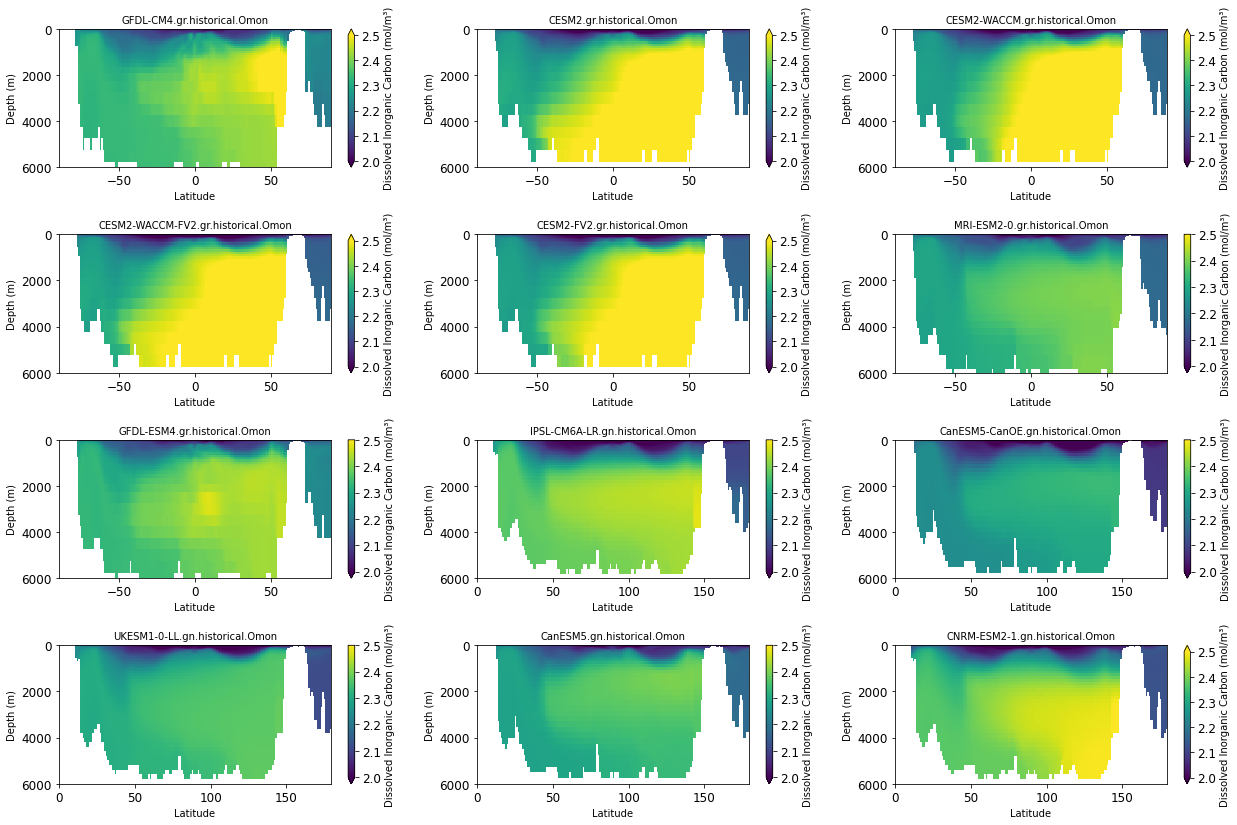

In [23]:
#You dont have to spell out all the axes, you can just keep them in an array
fig_DIC, axarr_DIC = plt.subplots(nrows = 4, ncols = 3, figsize=[18,12])
fig_DIC.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_DIC in dd_new_new.items():
    ax = axarr_DIC.flat[ax_idx]
    if np.max(ds_DIC.lon) > 180:
        DIC_section = ds_DIC.dissic.where(np.logical_and(ds_DIC.lon<=200, ds_DIC.lon>=180), drop=True).isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)
    else:
        DIC_section = ds_DIC.dissic.where(np.logical_and(ds_DIC.lon<=-160, ds_DIC.lon>=-180), drop=True).isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)
    im = DIC_section.plot(x='y', y='lev', yincrease=False, vmin = 2.0, vmax = 2.5, ax = ax, cbar_kwargs={'label':'Dissolved Inorganic Carbon (mol/m\u00b3)'})
    ax.set_title(name)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim([6000, 0])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

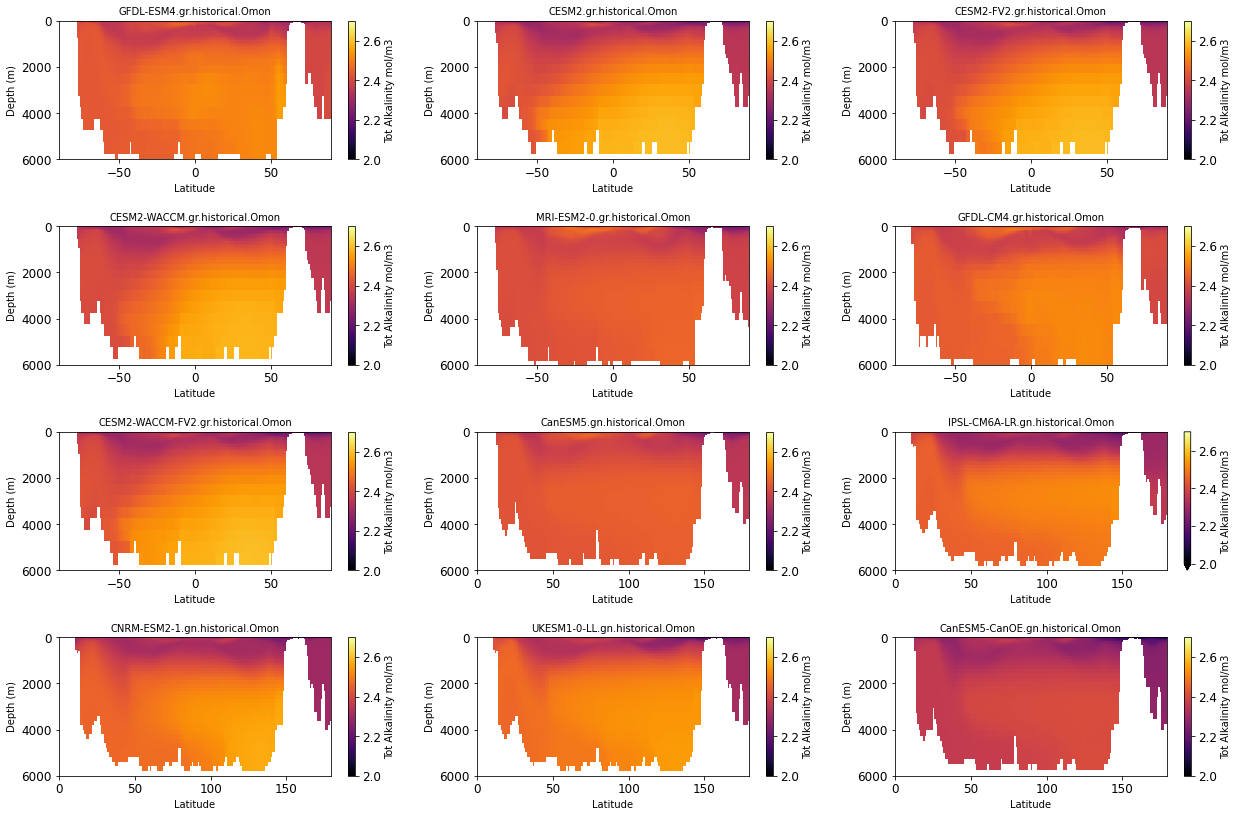

In [8]:
#You dont have to spell out all the axes, you can just keep them in an array
fig_talk, axarr_talk = plt.subplots(nrows = 4, ncols = 3, figsize=[18,12])
fig_talk.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_DIC in dd_new_new.items():
    ax = axarr_talk.flat[ax_idx]
    if np.max(ds_DIC.lon) > 180:
        DIC_section = ds_DIC.talk.where(np.logical_and(ds_DIC.lon<=200, ds_DIC.lon>=180), drop=True).isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)
    else:
        DIC_section = ds_DIC.talk.where(np.logical_and(ds_DIC.lon<=-160, ds_DIC.lon>=-180), drop=True).isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)
    im = DIC_section.plot(x='y', y='lev', yincrease=False, cmap = 'inferno', vmin = 2, vmax = 2.7, ax = ax, cbar_kwargs={'label':'Tot Alkalinity mol/m3'})
    ax.set_title(name)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim([6000, 0])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

In [ ]:
#You dont have to spell out all the axes, you can just keep them in an array
fig_thetao, axarr_thetao = plt.subplots(nrows = 4, ncols = 3, figsize=[18,12])
fig_thetao.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_DIC in dd_new_new.items():
    ax = axarr_thetao.flat[ax_idx]
    if np.max(ds_DIC.lon) > 180:
        DIC_section = ds_DIC.thetao.where(np.logical_and(ds_DIC.lon<=200, ds_DIC.lon>=180), drop=True).isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)
    else:
        DIC_section = ds_DIC.thetao.where(np.logical_and(ds_DIC.lon<=-160, ds_DIC.lon>=-180), drop=True).isel(time = slice(0, 239)).mean(['time', 'x'], keep_attrs=True)
    im = DIC_section.plot(x='y', y='lev', cmap = 'RdBu_r', yincrease=False, vmin = -2, vmax = 25, ax = ax, cbar_kwargs={'label':'Tot Alkalinity mol/m3'})
    ax.set_title(name)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim([6000, 0])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one